In [1]:
import gpmultipy, scipy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from gpmultipy import dataset
from gpmultipy.model import Model
from gpmultipy.prior import Prior
from gpmultipy.kernel import RBF, White
from gpmultipy.freeze import Freezer
from gpmultipy.sampler.slice import Slice
from gpmultipy.kernel import Product, Linear

In [3]:
%matplotlib inline

In [4]:
ds = dataset.DataSet('data/')
x,y,effect,labels = ds.build(Strain='ura3',mM_PQ=0.0,scale='range',Bio='E')
y = (y-y.mean())/y.std()

dm = np.ones((y.shape[1],1))

In [5]:
yKernel = White(1,.1)
k1 = RBF(1,1,1)

# yKernel = White(1,1)
# k1 = RBF(1,1,1)

p = y.shape[1]
dm = np.ones((1,p))

prior = Prior(x,k1,range(dm.shape[0]))

model = Model(x,y,dm)

In [9]:
ySigmaSlice = Slice('ySigma',
                    lambda x: model.dataLikelihood(yKernel,sigma=x),
                    #lambda x: scipy.stats.uniform(1e-6,1e0).logpdf(x),
                    #lambda x: scipy.stats.lognorm(1,loc=1e-2,scale=1e-1).logpdf(x),
                    lambda x: scipy.stats.lognorm(1,scale=1e-0).logpdf(x),
                    #debug_lognorm,
                    .2,5,logspace=True)

kSigmaSlice = Slice('kSigma',
                    lambda x: prior.loglikelihood(model.beta,sigma=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    #debug_unif,
                    .2,5,logspace=True)

kLengthscaleSlice = Slice('kLengthscale',
                    lambda x: prior.loglikelihood(model.beta,lengthscale=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

samples = []
freeze = Freezer(yKernel=yKernel,k1=k1,model=model)

In [10]:
thin = 10
burnin = 0
nsample = 1000

for i in range(nsample):
    prior.sample(model,yKernel)

    k1.sigma = kSigmaSlice.sample(k1.sigma)
    yKernel.sigma = ySigmaSlice.sample(yKernel.sigma)
    k1.lengthscale = kLengthscaleSlice.sample(k1.lengthscale)

    if i % thin == 0 and i > burnin:
        print model.dataLikelihood(yKernel),yKernel.sigma, k1.sigma, k1.lengthscale
        samples.append(freeze.freeze())

190.164029913 0.0440784927561 2.99388328334 0.284236284347
188.404086539 0.0458014777881 2.22744298809 0.259320667339
181.3884383 0.0472293503336 1.36519354414 0.305673281845
189.314521253 0.0481471097741 2.01571271087 0.268545433361
187.801680185 0.0454621220218 2.0355104661 0.28068648849
187.381577599 0.0451937477691 1.5038059195 0.225244171884
189.710736206 0.0467357405648 0.98641690073 0.202369887818
190.496982869 0.0452702090754 0.682099979965 0.200706348074
188.841502784 0.0486799612628 1.63611597293 0.221906758829
187.26197292 0.0475975772813 0.852790874822 0.215461150852
189.131586916 0.0459891019949 1.19315243416 0.253157759308
188.006038666 0.0474660869858 1.68782937032 0.209504924483
185.480975673 0.0424136726675 0.719896402101 0.164316082128
191.00173223 0.0444588496979 0.970339480744 0.173403148333
188.323344009 0.0475340998198 0.736862455907 0.18878065068
188.87285582 0.04729278372 0.444153047945 0.17463099214
186.731376571 0.0433914406402 0.465739431399 0.214191075746
19

(array([  2.,   2.,   7.,  15.,  26.,  22.,  12.,   8.,   2.,   3.]),
 array([-0.87702322, -0.83299742, -0.78897162, -0.74494582, -0.70092002,
        -0.65689422, -0.61286842, -0.56884262, -0.52481682, -0.48079102,
        -0.43676522]),
 <a list of 10 Patch objects>)

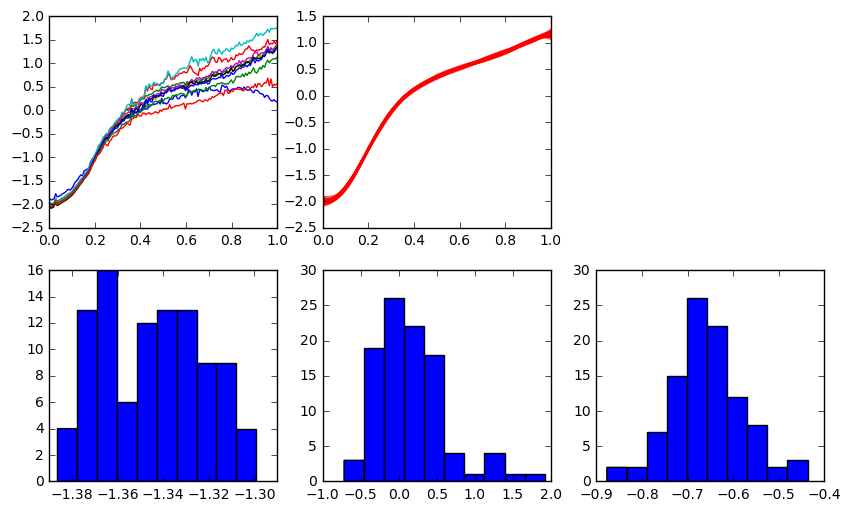

In [11]:
plt.figure(figsize=(10,6))
plt.subplot(231)
plt.plot(x,y)

plt.subplot(232)
plt.plot(x,np.array([s['model']['beta'][:,0] for s in samples]).T,c='r',alpha=.5)

plt.subplot(234)
plt.hist(np.log10([s['yKernel']['sigma'] for s in samples]))

plt.subplot(235)
plt.hist(np.log10([s['k1']['sigma'] for s in samples]))

plt.subplot(236)
plt.hist(np.log10([s['k1']['lengthscale'] for s in samples]))

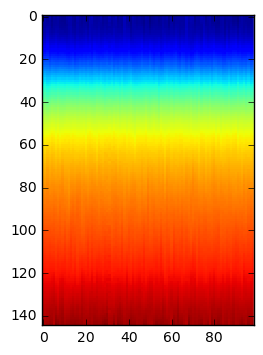

In [19]:
plt.imshow(mu,interpolation='none')

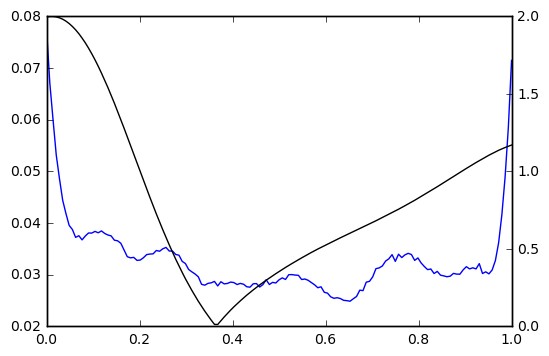

In [16]:
mu = np.array([s['model']['beta'][:,0] for s in samples]).T

plt.plot(x,mu.std(1)*2);

plt.twinx()
plt.plot(x,abs(mu.mean(1)),c='k');

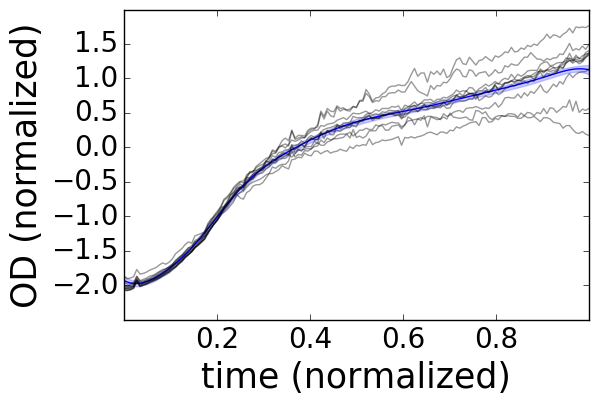

In [34]:
plt.figure(figsize=(6,4))

# gpfanova.plot.plotFunctionSamples(m_noReplicate.functionSamples(0).values,x=x[:,0])
plt.plot(x[:,0],y,c='k',alpha=.4)

plt.xlabel("time (normalized)",fontsize=25)
plt.ylabel("OD (normalized)",fontsize=25)
plt.xticks(np.arange(.2,1,.2),fontsize=20)
plt.yticks(np.arange(-2,2,.5),fontsize=20)

plt.savefig("figures/ura3-pq-replicate/model-noReplicate-singleReplicate.pdf",bbox_inches='tight',dpi=300)

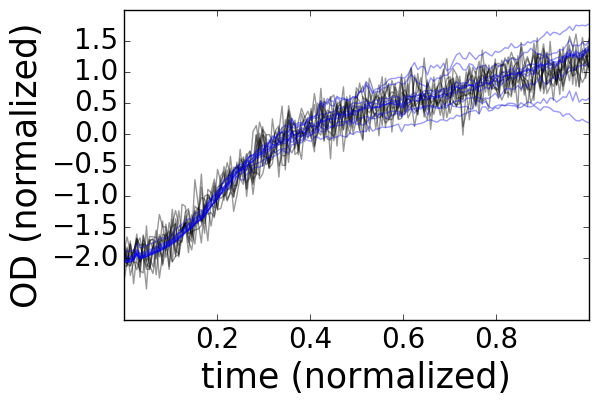

In [26]:
plt.figure(figsize=(6,4))

mu = samples[-1]['model']['beta'][:,0]
cov = yKernel.K(x)
ysample = mu + scipy.stats.multivariate_normal.rvs(np.zeros(x.shape[0]),cov,size=model.r)

plt.plot(x[:,0],ysample.T,c='k',alpha=.4); 
plt.plot(x[:,0],y,c='b',alpha=.4); 
# plt.plot(x[:,0],fsample,c='r',lw=3);

plt.xlabel("time (normalized)",fontsize=25)
plt.ylabel("OD (normalized)",fontsize=25)
plt.xticks(np.arange(.2,1,.2),fontsize=20)
plt.yticks(np.arange(-2,2,.5),fontsize=20)

plt.savefig("figures/model-noEffect-generative.pdf",bbox_inches='tight',dpi=300)